# Processing guidelies: 
1. Downsample to 512
2. reference to Cz
3. filter ([.1,120] and line noise)
4. remove bad channels (not done here)
5. Epoch data 
6. inspect epochs (not done here)
7. dump as array


In [1]:
import json
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import mne
import numpy as np
import os
import pandas as pd
import pyxdf
import seaborn as sns

In [2]:
"""
Get the EEG data from xdf file. 
The xdf contains both the EEG and the eye tracking data.
Read xdf and extract just the EEG
"""
datasrc = "../data"
datafile = "P001_block_1.xdf"
montagefile = "ANT_EEG_channel_mapping.json"

Fetch the data and basic summarization

1. Load the block
2. Gather the summary of the EEG channels
3. Gather summary of the triggers
4. Create the event array in mne format
5. Load EEG into mne

In [3]:
data, header = pyxdf.load_xdf(datafile)

In [4]:
# what are the various stream
for i in range(len(data)):
    print(data[i]["info"]['name'])

['openvibeSignal']
['ToolCueOrientationString']
['ToolCueOrientationInt']
['EyeTrackingGazeHMDFloat']
['Input']
['TimeStamps']
['openvibeMarkers']
['ObjectShownTimeStamp']
['BeepPlayedTimeStamp']
['CueTimeStamp']
['CueDisappearedTimeStamp']
['ButtonPressedTimeStamp']
['TrialStartMeasurementTimeStamp']
['FrameTracking']
['TrialStopMeasurementTimeStamp']
['EyeTrackingGazeHMDString']
['GazeValidity']


In [5]:
#index of the EEG stream
eeg_stream = 0
#index of the triggers
stim_streams = [9, #'CueTimeStamp',
                10, #'CueDisappearedTimeStamp',
                7, #'ObjectShownTimeStamp',
                8, #'BeepPlayedTimeStamp',
                11] # 'ButtonPressedTimeStamp'

#map triggers & event ids & descriptions 
event_mapping = {'task': 1, 
                 'inter-task-object': 2,
                 'object': 3, 
                 'action': 4, 
                 'inter-trial':5} 

In [6]:
#info about the EEG stream
data[eeg_stream]['info']

defaultdict(list,
            {'name': ['openvibeSignal'],
             'type': ['signal'],
             'channel_count': ['72'],
             'channel_format': ['float32'],
             'source_id': ['(0x4f7c10f7, 0xef68d979)'],
             'nominal_srate': ['1024.000000000000'],
             'version': ['1.100000000000000'],
             'created_at': ['4457.708789200000'],
             'uid': ['4e32953a-94b5-4e9b-85e0-41a4d2c3fbc9'],
             'session_id': ['default'],
             'hostname': ['wd-left'],
             'v4address': [None],
             'v4data_port': ['16572'],
             'v4service_port': ['16572'],
             'v6address': [None],
             'v6data_port': ['16572'],
             'v6service_port': ['16572'],
             'desc': [defaultdict(list,
                          {'channels': [defaultdict(list,
                                        {'channel': [defaultdict(list,
                                                      {'label': ['ExG1'],
       

In [7]:
#get the eeg timestamps and reset them to start at t=0
eeg_time = data[eeg_stream]["time_stamps"] - data[eeg_stream]["time_stamps"][0]
print("duration of the recording {}".format(eeg_time[-1]))

duration of the recording 724.4990275940463


In [8]:
#sampling rate recorded by LSL
sr = data[eeg_stream]['info']['effective_srate']
print(sr)

1023.9999941251851


In [9]:
#extract info about the channels and set-up for mne
n_ch = int(data[eeg_stream]['info']['channel_count'][0])
ch_typ= ['eeg'] * n_ch

with open(montagefile) as f: #open the montage file provided by Debbie
    montage = json.loads(f.read())

#change channel names to match standard naming convention in mne standard montage
montage['ch-1']='Fp1'
montage['ch-2']='Fpz'
montage['ch-3']='Fp2'

ch_names = []
temp = data[eeg_stream]['info']['desc'][0]['channels'][0]['channel']
for i in range(n_ch):
    n = temp[i]['label'][0].replace("ExG","ch-")
    ch_names.append(montage[n] if "ch-" in n else n)
print(ch_names)

['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CPz', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'BIP65', 'BIP66', 'BIP67', 'BIP68', 'AUX69', 'AUX70', 'AUX71', 'AUX72']


In [10]:
# Extract the triggers and concatenate them
tmpevents = []
for i, stim_idx in enumerate(stim_streams):
    x = np.searchsorted(data[eeg_stream]["time_stamps"],data[stim_idx]["time_stamps"])
    y = np.zeros((x.shape[0],3),dtype=int)
    y[:,0] = x
    y[:,2] = np.full(x.shape[0], i+1, dtype=int)
    tmpevents.append(y)
    
events = np.concatenate(tmpevents) 
sort_idx = np.argsort(events[:,0])
events = events[sort_idx]

In [11]:
def inspect_events(evt_arr,event_map,sfreq):
    #inspect the consistency of the triggers
    evntlist = {desc:idx for idx, desc in event_map.items()}
    df=pd.DataFrame({'sample_id':evt_arr[:,0], 'dummy':evt_arr[:,1],'event_id':evt_arr[:,2]})
    df['event_id'].replace(evntlist,inplace=True)
    df['dur'] = df['sample_id'].diff(-1)*-1/sfreq
    df = df[pd.notna(df['dur'])]

    for i in event_map.keys():
        d = df.loc[df['event_id']==i,'dur']
        print("Summary: {}".format(i))
        print("\tmean: {:6.4f}".format(d.mean()))
        print("\tmedian: {:6.4f}".format(d.median()))
        print("\tstd div: {:6.4f}".format(d.std()))

    %matplotlib inline
    fig, ax = plt.subplots(figsize=(10,6))
    sns.boxplot(data=df[pd.notna(df['dur'])],y='dur',x='event_id',ax=ax)
    ax.set_xlabel("Events")
    ax.set_ylabel("Duration (s)")
    plt.show()
    
    return

Summary: task
	mean: 2.0127
	median: 2.0127
	std div: 0.0012
Summary: inter-task-object
	mean: 0.5113
	median: 0.5117
	std div: 0.0026
Summary: object
	mean: 3.0087
	median: 3.0088
	std div: 0.0007
Summary: action
	mean: 4.5675
	median: 4.4146
	std div: 1.8848
Summary: inter-trial
	mean: 1.0187
	median: 1.0186
	std div: 0.0018


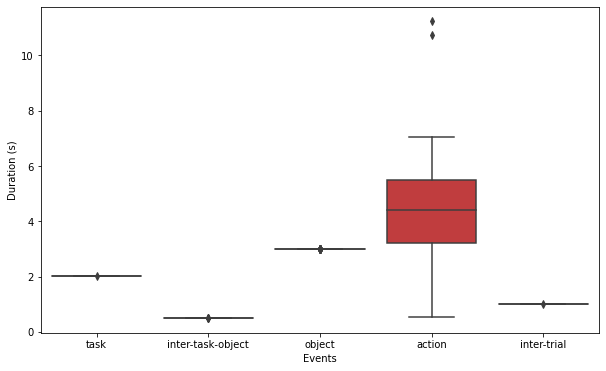

In [12]:
inspect_events(events,event_mapping,sr)

In [28]:
#create mne info
info = mne.create_info(ch_names, ch_types=ch_typ, sfreq=sr)
#print(info)

In [29]:
#mne data array should be in (nChannel,nSamples) whereas xdf stores in (nSamples,nChannel)
eeg = mne.io.RawArray(np.transpose(data[eeg_stream]["time_series"]), info) 

Creating RawArray with float64 data, n_channels=72, n_times=741888
    Range : 0 ... 741887 =      0.000 ...   724.499 secs
Ready.


In [30]:
#drop auxiliaries and not needed channels
#set the montage
eeg.drop_channels(['BIP65', 'BIP66', 'BIP67', 'BIP68', 'AUX69', 'AUX70', 'AUX71', 'AUX72'])
eeg.set_montage('standard_1020')

<RawArray | 64 x 741888 (724.5 s), ~362.3 MB, data loaded>

In [31]:
#resample to 512Hz
#Note: the raw and the event are resampled simultaneously so that they stay more or less in synch.
eeg_resamp, events_resamp = eeg.resample(sfreq=512,events=events)

In [32]:
#EEG is recorded with average reference. Re-refer to Cz
eeg_resamp.set_eeg_reference(ref_channels=['Cz'])

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawArray | 64 x 370944 (724.5 s), ~181.2 MB, data loaded>

Using matplotlib as 2D backend.


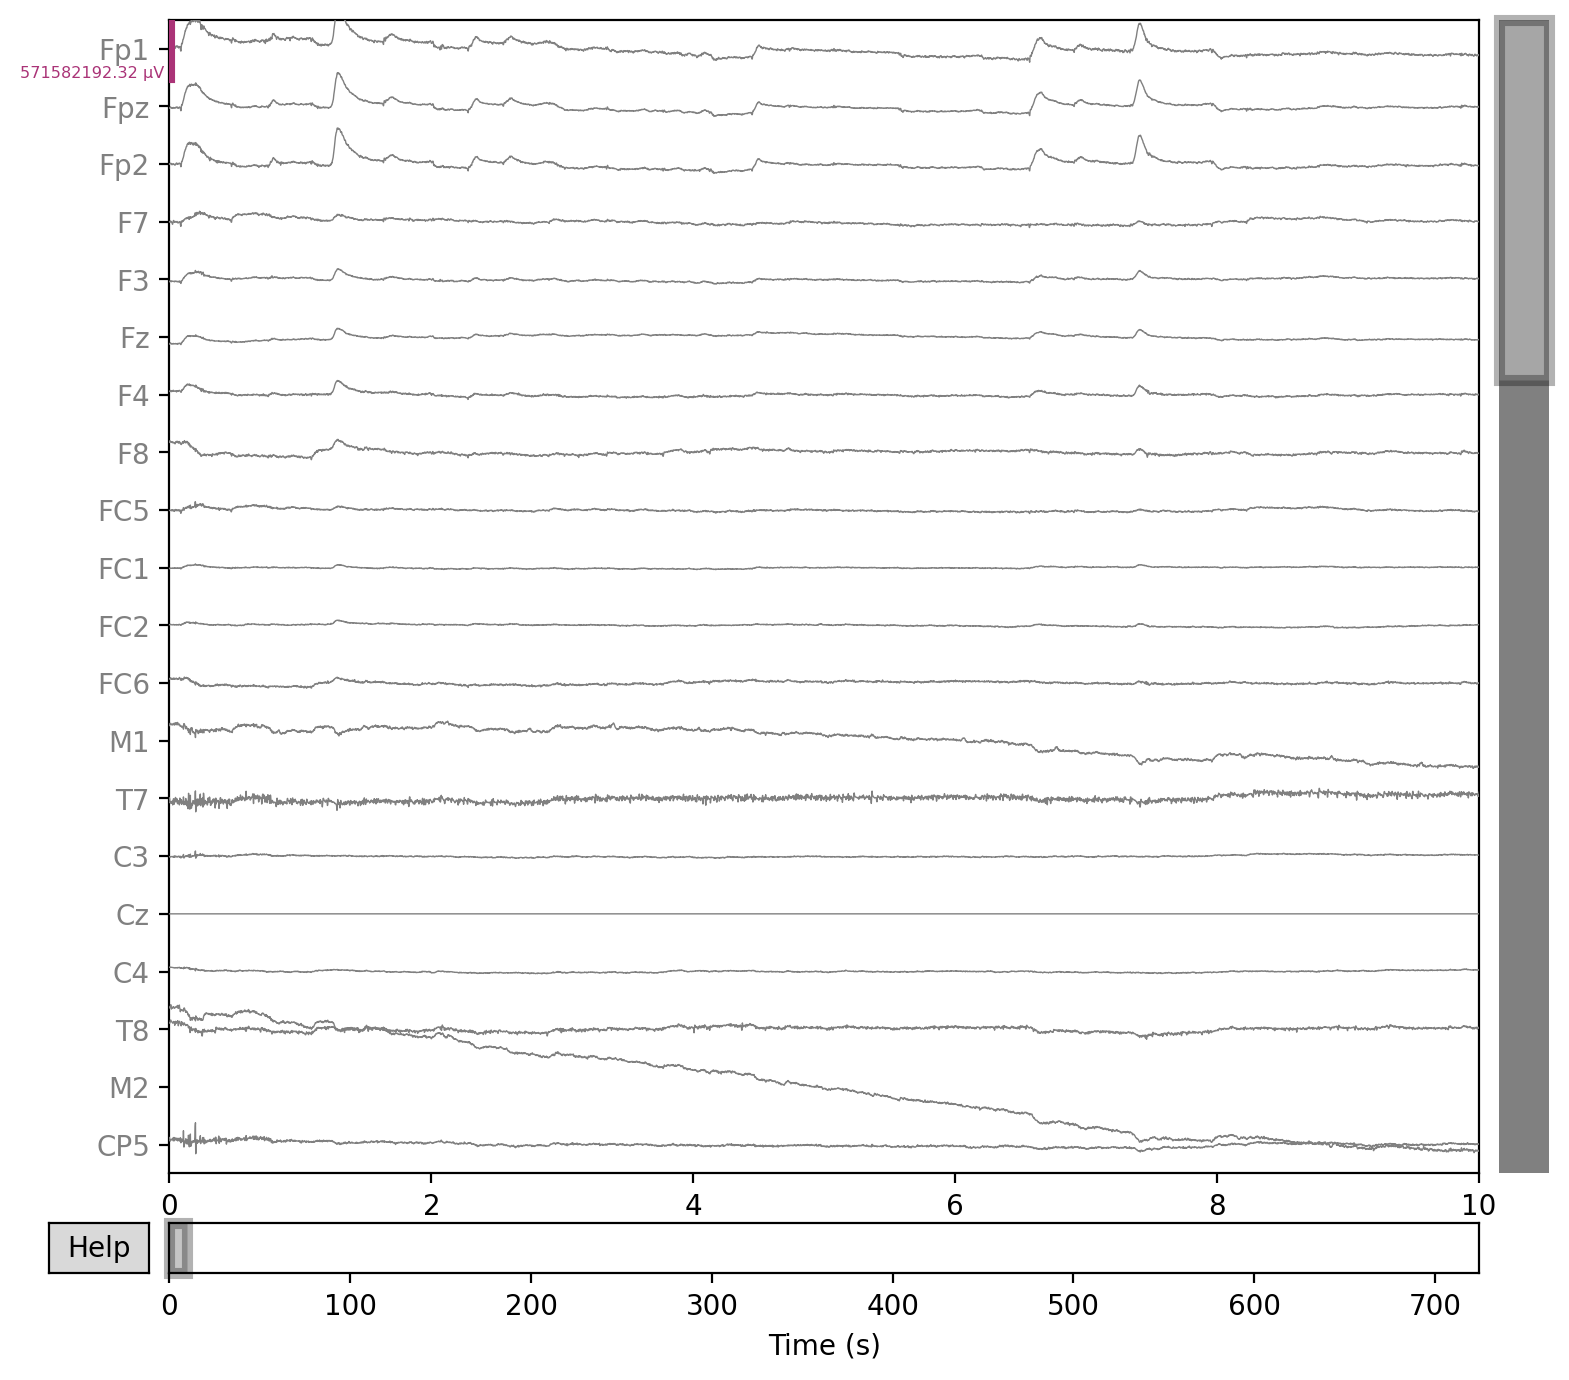

In [18]:
%matplotlib qt
eeg_resamp.plot(events=events_resamp,scalings='auto',event_color={1: 'r', 2: 'g', 3: 'b'},color='gray')

In [19]:
#inspect the resampled events once more 
#inspect_events(events_resamp,event_mapping,eeg_resamp.info['sfreq'])

Effective window size : 4.000 (s)


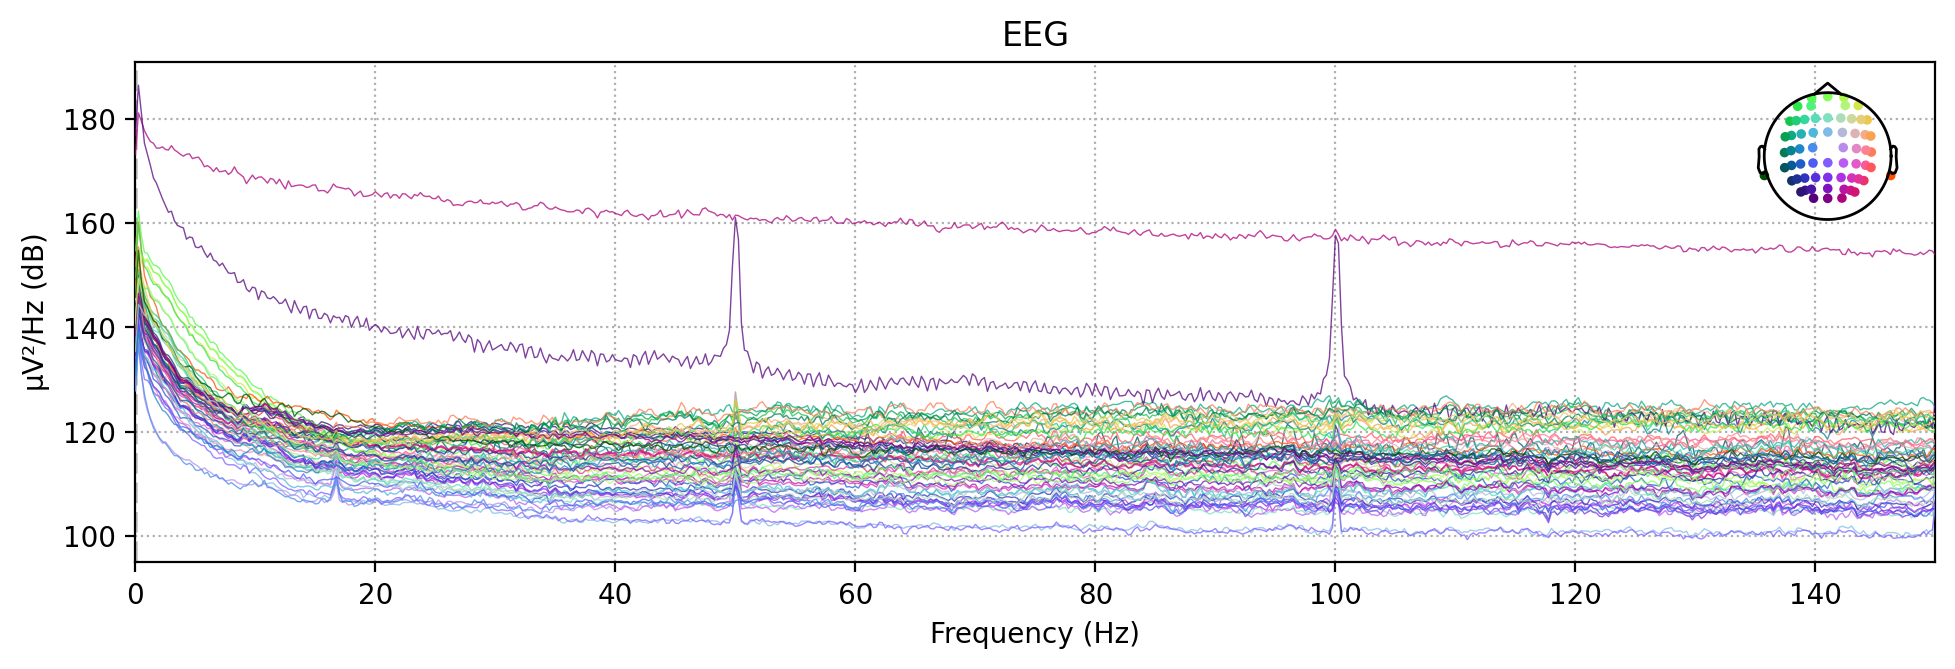

In [33]:
#Check the spectral power 
eeg_resamp.plot_psd(average=False,fmax=150,exclude=['Cz'])

# Note: Both 50 hz and the next harmonic has spikes ...so filtered out both 
Should we always check this line noise removal manually?

In [34]:
#Filter resampled EEG
#High pass 0.1 Hz
#Low pass 120 Hz
#notch 50Hz,100Hz
eeg_resamp.filter(l_freq=0.1, h_freq=120)
eeg_resamp.notch_filter(freqs=[50,100])

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 16897 samples (33.002 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)



<RawArray | 64 x 370944 (724.5 s), ~181.2 MB, data loaded>

Effective window size : 4.000 (s)


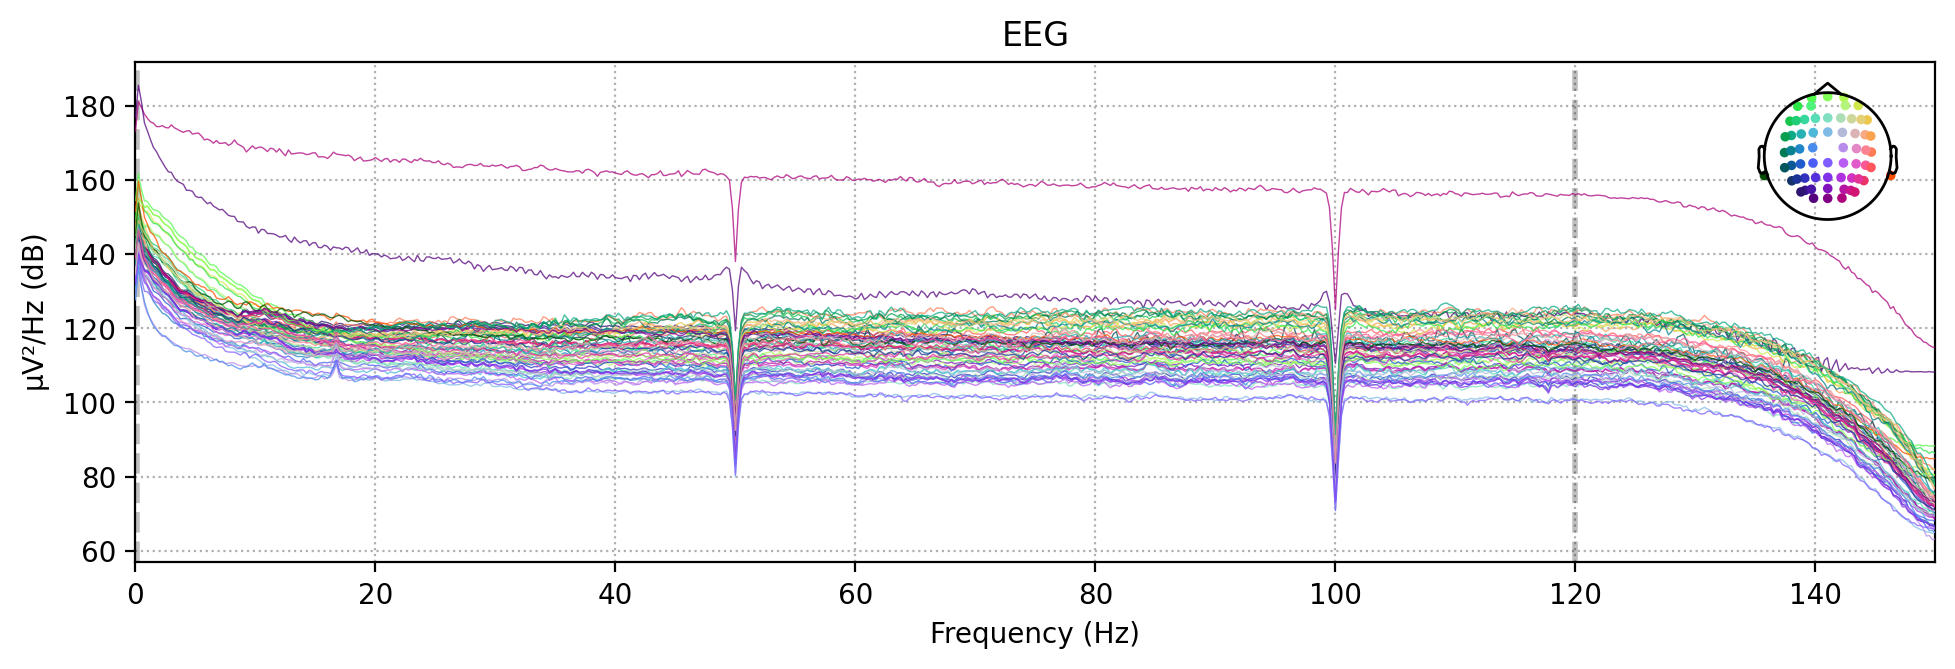

In [35]:
eeg_resamp.plot_psd(average=False,fmax=150,exclude=['Cz'])

In [47]:
#Our epochs are trials not these events per se
#trial start: Task cue
#trial end next Task cue (we have the button press but we ignore them since analysis beyond the action phase is not done as of now)
epoch_events = events_resamp[events_resamp[:,2]==1]
epoch_events_map = {'trial': 1}
                 #'inter-trial':5} 


In [48]:
#epochs paramaters
tmin = -0.1 # 100 msec before the event boundary
tmax = 6.0 # each trial is 2.0 + 0.5 + 3.0 + 0.5...NOTE: first 0.5 sec of action is included
baseline = (tmin,0) #i.e. the entire zone from tmin to 0

In [49]:
epochs = mne.Epochs(eeg_resamp, epoch_events, event_id=[1], tmin=tmin)

Not setting metadata
Not setting metadata
48 matching events found
Setting baseline interval to [-0.099609375, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


In [50]:
print(epochs)

<Epochs |  48 events (good & bad), -0.0996094 - 0.5 sec, baseline -0.0996094 – 0 sec, ~90 kB, data not loaded,
 '1': 48>


Loading data for 48 events and 308 original time points ...
0 bad epochs dropped
Loading data for 48 events and 308 original time points ...
Loading data for 3 events and 308 original time points ...


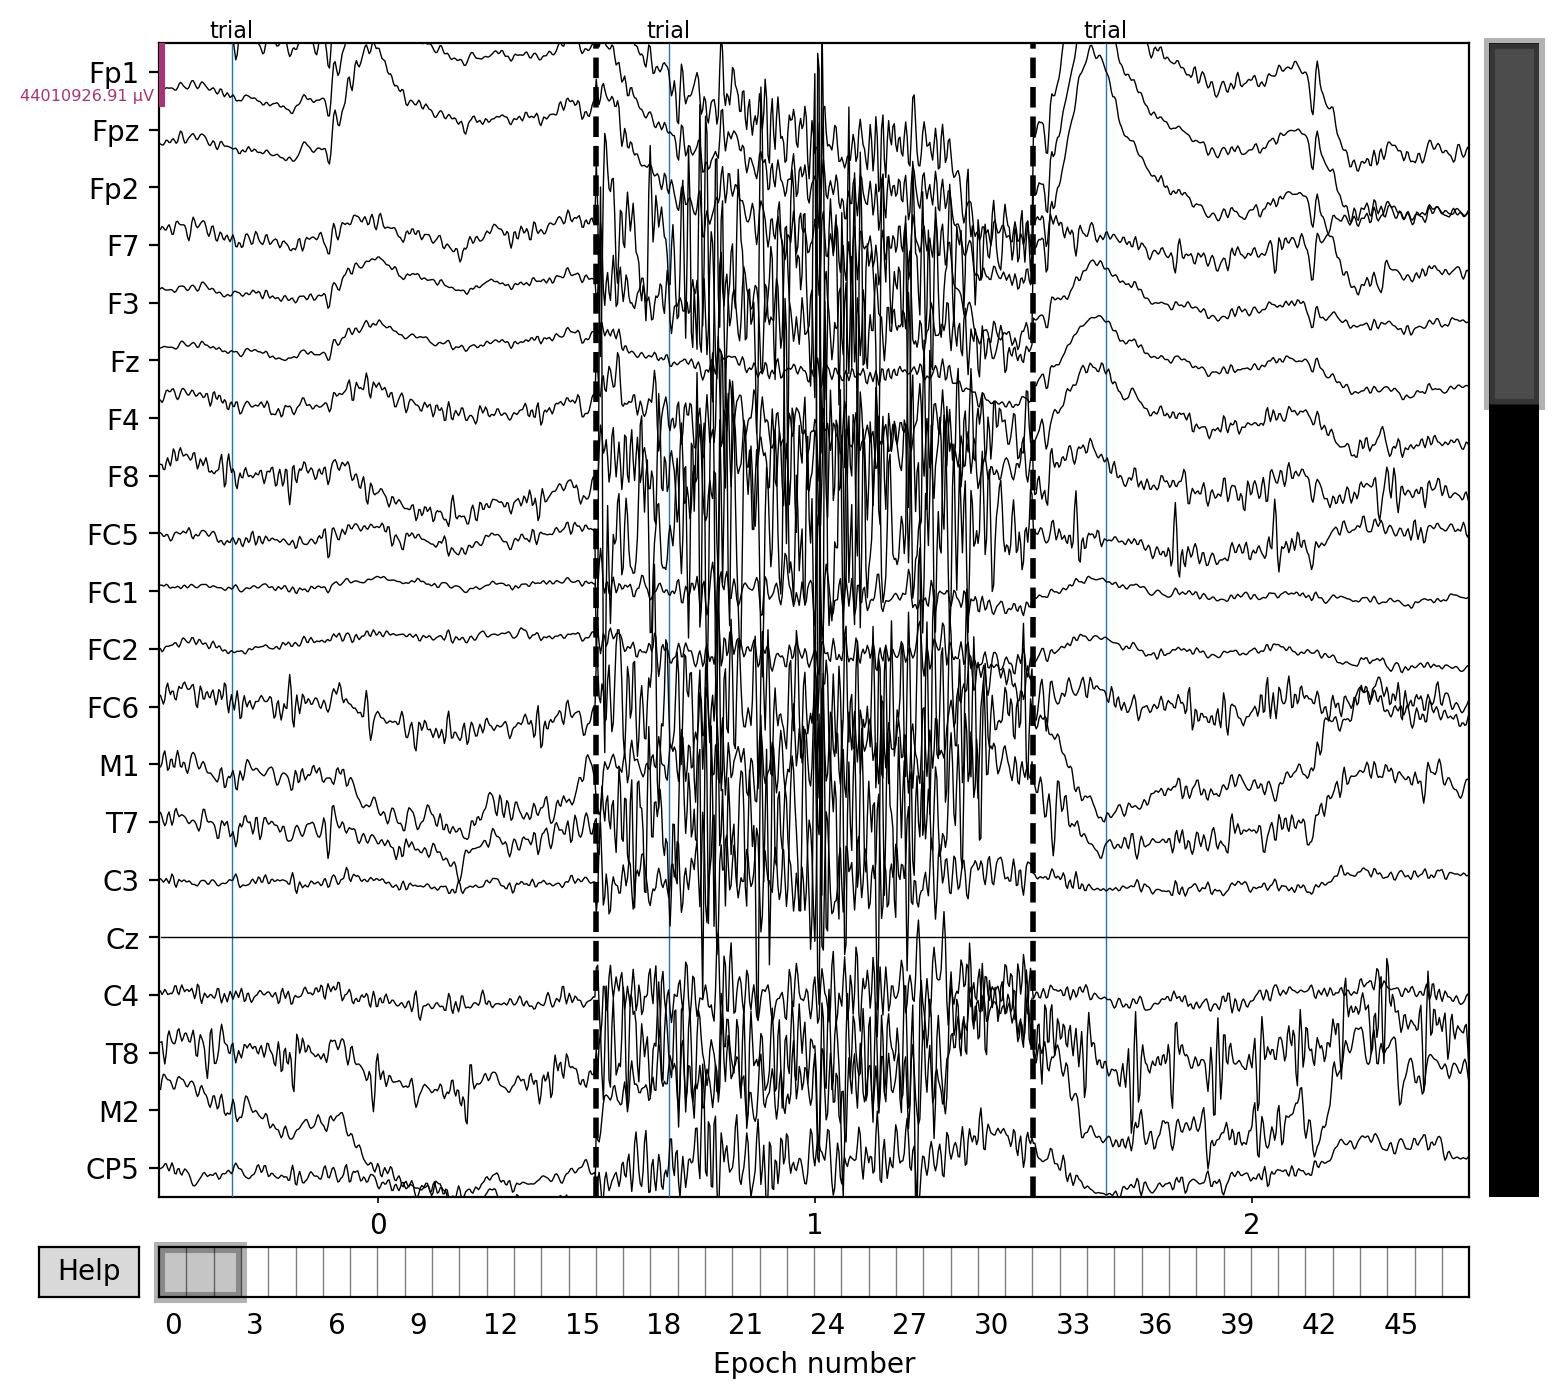

Dropped 0 epochs: 
Channels marked as bad: none


In [51]:
epochs.plot(scalings='auto',n_epochs=3,
            events=epoch_events,event_id=epoch_events_map)

In [55]:
#convert to numpy array
epoch_array = epochs.get_data()

Loading data for 48 events and 308 original time points ...


In [56]:
#save the array
with open('P001_block_1.npy', 'wb') as f:
    np.save(f, epoch_array)